In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [2]:
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [3]:
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

In [4]:
unique_dates = list(set(dates))

repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [5]:
# Create a class for linear regression
class LinearRegression:
    def __init__(self, step_size=1e-3, max_iter=10000, eps=1e-4, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps

    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
        
    def predict(self, x):
        z = np.dot(x.T, self.theta)
        return self.sigmoid(z)
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        for i in range(x_teams.shape[0]):
            x = x_teams[i,:]
            x_new = np.reshape(x, (2*num_players + 1, 1))
            y = np.asscalar(y_teams[i])
            update += (self.predict(x_new) - y)*x_new
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size):
        update = 0
        data = np.array(list(zip(x_teams, y_teams)))
        data_shuffle = data
        np.random.shuffle(data_shuffle)
        
        for i in range(batch_size):
            x = data[i, :]
            y = data[:, i]
            update += (self.predict(x) - y)*x
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players + 1, 1))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new
                
                if iterations % 100 == 0: 
                    print('Error {}: {}'.format(iterations, abs_error))

                iterations += 1
        else:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1
                
                if iterations % 100 == 0: 
                    print('Error {}: {}'.format(iterations, abs_error))
        
        print('Convergence!')
        plt.plot(error_list)
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:,0]
            
        x = self.add_intercept(x_without_intercept)
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1]+1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
        
    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2
    
    def general_predict(self, teams, dates, results): 
        test_x, test_y = self.process_data(teams, dates, results)
        
        predicted_y = []
        for i in range(test_x.shape[0]):
            x = test_x[i,:]

            x_new = np.reshape(x, (2*num_players + 1, 1))
            prediction = self.predict(x_new)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        return np.mean(np.array(predicted_y) == np.array(test_y.T))
    
    def playoff_prediction(self, playoff_filename, playoff_date): 
        #Load playoff data
        playoff_data = pd.read_csv(os.path.join(curr_directory, playoff_filename))

        raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
        raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
        raw_playoff_dates = np.array(list(playoff_data['Date']))

        playoff_pairs = {}

        for i in range(len(raw_playoff_team_pairs)): 
            team_1 = raw_playoff_team_pairs[i][0]
            team_2 = raw_playoff_team_pairs[i][1]
            if (team_1,team_2) in playoff_pairs.keys(): 
                # if results > 0 --> team A won --> +1
                # if results < 0 --> team B won --> -1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] += 1
                else: 
                    playoff_pairs[team_1,team_2] += -1
            elif (team_2,team_1) in playoff_pairs.keys():
                # if results > 0 --> team B won --> -1
                # if results < 0 --> team A won --> +1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_2,team_1] += -1
                else: 
                    playoff_pairs[team_2,team_1] += 1
            else: 
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] = 1
                else: 
                    playoff_pairs[team_1,team_2] = -1

        playoff_teams = []
        playoff_results = []
        playoff_dates = []

        for key in playoff_pairs: 
            playoff_teams.append([key[0], key[1]])
            playoff_results.append(playoff_pairs[key])
            playoff_dates.append(playoff_date)

        playoff_teams = np.array(playoff_teams)
        playoff_results = np.array(playoff_results)
        playoff_dates = np.array(playoff_dates)

        playoff_x, playoff_y = self.process_data(playoff_teams, playoff_dates, playoff_results)

        predicted_y = []
        predictions = []

        for i in range(playoff_x.shape[0]):
            x = playoff_x[i,:]
            x_new = np.reshape(x, (2*num_players + 1, 1))
            prediction = self.predict(x_new)
            predictions.append(prediction)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)

        prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

        return prediction_accuracy

Error: 0.14041901580626467
Error: 0.01536608755671719
Error: 0.008489104236391392
Error: 0.00570550460573614
Error: 0.004222116735263241
Error: 0.00331997375598307
Error: 0.002725219667153639
Error: 0.002310315877650014
Error: 0.002007766865425967
Error: 0.0017787741377170278
Error: 0.001599786260969493
Error: 0.001455940719320204
Error: 0.0013375605610161856
Error: 0.0012381663584069942
Error: 0.0011533025762909196
Error: 0.0010798251897046526
Error: 0.0010154595649670872
Error: 0.0009585205252235715
Error: 0.0009077316238537726
Error: 0.0008621061632755614
Error: 0.0008208672979359263
Error: 0.000783393303031475
Error: 0.0007491793318471832
Error: 0.0007178101700022383
Error: 0.000688940456872597
Error: 0.0006622800693352198
Error: 0.0006375831383018807
Error: 0.0006146396662699939
Error: 0.0005932690383503288
Error: 0.0005733149335850385
Error: 0.0005546412872312915
Error: 0.0005371290527143673
Error: 0.0005206735797709195
Error: 0.0005051824729255203
Error: 0.0004905738283753381
Er

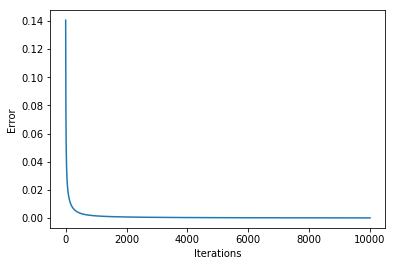

Dev Accuracy: 0.5428571428571428
Playoff Accuracy: 0.5333333333333333


In [6]:
# Playoff Training for 2014-2015 Season
train_2014 = LinearRegression()

teams_14 = np.copy(unique_teams[0:1229])
dates_14 = np.copy(unique_dates[0:1229])
results_14 = np.copy(unique_game_results[0:1229])

teams_14, dates_14, results_14 = shuffle(teams_14, dates_14, results_14, random_state=0)
x_train_14, y_train_14 = train_2014.process_data(teams_14[0:983], dates_14[0:983], results_14[0:983])

train_2014.fit(x_train_14, y_train_14)

dev_accuracy_14 = train_2014.general_predict(teams_14[984:1229], dates_14[984:1229], results_14[984:1229])
print('Dev Accuracy: {}'.format(dev_accuracy_14))

prediction_2014 = train_2014.playoff_prediction('data_sets/2015_playoffs.csv', '2015-04-10')
print('Playoff Accuracy: {}'.format(prediction_2014))

Error: 0.15918542646863124
Error: 0.017338870928617092
Error: 0.009939495559205262
Error: 0.006972864520855116
Error: 0.0053622315714018974
Error: 0.0043525644119904346
Error: 0.003662941220502781
Error: 0.0031638243956141864
Error: 0.0027868374454178275
Error: 0.00249245131412446
Error: 0.0022562921785744174
Error: 0.0020625863364951464
Error: 0.001900726263373688
Error: 0.0017633467192857608
Error: 0.0016451903783709259
Error: 0.0015424116828961496
Error: 0.0014521355122556173
Error: 0.0013721695901336756
Error: 0.0013008124880236665
Error: 0.0012367226106290113
Error: 0.001178826965582457
Error: 0.0011262564223718746
Error: 0.0010782989454115705
Error: 0.0010343652433843266
Error: 0.0009939631427188125
Error: 0.0009566781911884214
Error: 0.0009221587797245593
Error: 0.0008901045890734441
Error: 0.0008602575168981648
Error: 0.0008323944792262644
Error: 0.0008063216451912994
Error: 0.0007818697799202222
Error: 0.0007588904529073244
Error: 0.0007372529286850724
Error: 0.000716841600008

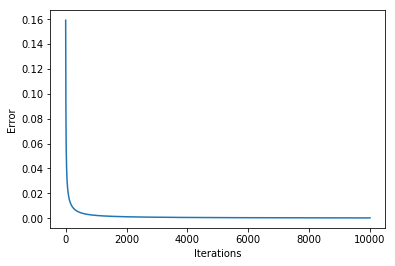

Dev Accuracy: 0.5795918367346938
Playoff Accuracy: 0.8


In [7]:
# Playoff Training for 2015-2016 Season
train_2015 = LinearRegression()

teams_15 = np.copy(unique_teams[1230:2459])
dates_15 = np.copy(unique_dates[1230:2459])
results_15 = np.copy(unique_game_results[1230:2459])

teams_15, dates_15, results_15 = shuffle(teams_15, dates_15, results_15, random_state=0)
x_train_15, y_train_15 = train_2015.process_data(teams_15[0:983], dates_15[0:983], results_15[0:983])

train_2015.fit(x_train_15, y_train_15)

dev_accuracy_15 = train_2015.general_predict(teams_15[984:1229], dates_15[984:1229], results_15[984:1229])
print('Dev Accuracy: {}'.format(dev_accuracy_15))

prediction_2015 = train_2015.playoff_prediction('data_sets/2016_playoffs.csv', '2016-04-10')
print('Playoff Accuracy: {}'.format(prediction_2015))

Error: 0.15177285659827322
Error: 0.015304689469985566
Error: 0.009305494095277889
Error: 0.006752088378895269
Error: 0.005284904928992003
Error: 0.004328955767181971
Error: 0.0036577878390612133
Error: 0.0031615599191041044
Error: 0.002780380969625812
Error: 0.0024788351097076488
Error: 0.0022346449285476715
Error: 0.002033097738391425
Error: 0.0018640873793503295
Error: 0.0017204439613506457
Error: 0.0015969415227306595
Error: 0.0014896828401997082
Error: 0.0013957040428096048
Error: 0.0013127124878896787
Error: 0.0012389082292238785
Error: 0.0011728595047221532
Error: 0.001113414063149301
Error: 0.0010596348320355779
Error: 0.0010107524686526663
Error: 0.0009661298444951717
Error: 0.000925235109574651
Error: 0.0008876210206888211
Error: 0.0008529089065876465
Error: 0.0008207761086723306
Error: 0.0007909460562639309
Error: 0.0007631803594682683
Error: 0.0007372724615869634
Error: 0.0007130425073257173
Error: 0.0006903331662890379
Error: 0.000669006212560158
Error: 0.00064893970679298

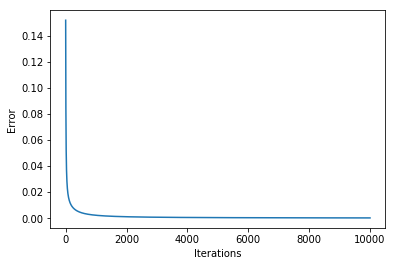

Dev Accuracy: 0.5836734693877551
Playoff Accuracy: 0.6


In [8]:
# Playoff Training for 2016-2017 Season
train_2016 = LinearRegression()

teams_16 = np.copy(unique_teams[2460:3689])
dates_16 = np.copy(unique_dates[2460:3689])
results_16 = np.copy(unique_game_results[2460:3689])

teams_16, dates_16, results_16 = shuffle(teams_16, dates_16, results_16, random_state=0)
x_train_16, y_train_16 = train_2016.process_data(teams_16[0:983], dates_16[0:983], results_16[0:983])

train_2016.fit(x_train_16, y_train_16)

dev_accuracy_16 = train_2016.general_predict(teams_16[984:1229], dates_16[984:1229], results_16[984:1229])
print('Dev Accuracy: {}'.format(dev_accuracy_16))

prediction_2016 = train_2016.playoff_prediction('data_sets/2017_playoffs.csv', '2017-04-10')
print('Playoff Accuracy: {}'.format(prediction_2016))

Error: 0.132208169187838
Error: 0.015792657158586035
Error: 0.009406041665768984
Error: 0.006653368802541749
Error: 0.005091658613122983
Error: 0.004084811828222009
Error: 0.0033859973795255928
Error: 0.002876864362877818
Error: 0.002492533861662411
Error: 0.00219417238804136
Error: 0.0019570929791298407
Error: 0.0017649044619555696
Error: 0.0016063587690007925
Error: 0.001473532321695878
Error: 0.0013607209644398246
Error: 0.0012637407152606079
Error: 0.0011794709160577194
Error: 0.0011055480175255043
Error: 0.0010401560158663562
Error: 0.0009818805278348358
Error: 0.0009296056561481275
Error: 0.0008824401293648154
Error: 0.000839663764051424
Error: 0.0008006882146882228
Error: 0.0007650278834551211
Error: 0.0007322781307171959
Error: 0.0007020987838790532
Error: 0.0006742015283229728
Error: 0.0006483401693727952
Error: 0.0006243030371564967
Error: 0.0006019070055415225
Error: 0.0005809927378732441
Error: 0.0005614208735829674
Error: 0.0005430689428284313
Error: 0.0005258288494492513


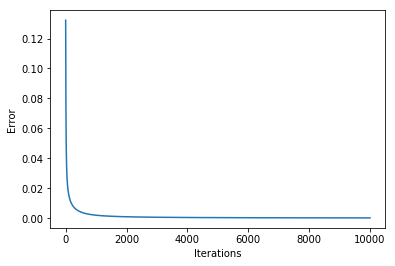

Dev Accuracy: 0.5918367346938775
Playoff Accuracy: 0.7333333333333333


In [9]:
# Playoff Training for 2017-2018 Season
train_2017 = LinearRegression()

teams_17 = np.copy(unique_teams[3690:4919])
dates_17 = np.copy(unique_dates[3690:4919])
results_17 = np.copy(unique_game_results[3690:4919])

teams_17, dates_17, results_17 = shuffle(teams_17, dates_17, results_17, random_state=0)
x_train_17, y_train_17 = train_2017.process_data(teams_17[0:983], dates_17[0:983], results_17[0:983])

train_2017.fit(x_train_17, y_train_17)

dev_accuracy_17 = train_2017.general_predict(teams_17[984:1229], dates_17[984:1229], results_17[984:1229])
print('Dev Accuracy: {}'.format(dev_accuracy_17))

prediction_2017 = train_2017.playoff_prediction('data_sets/2018_playoffs.csv', '2018-04-10')
print('Playoff Accuracy: {}'.format(prediction_2017))

In [10]:
# Parameter Examination -- doesn't really make a ton of sense to do this with linear regression...
indices_2014 = np.argsort(train_2014.theta, axis=0)[-20:]
print(list(all_players)[231 % 963])
print(list(all_players)[852 % 963])
print(list(all_players)[995 % 963])
print(list(all_players)[1837 % 963])
print(list(all_players)[1534 % 963])

Rodney Hood
Amar'e Stoudemire
Harrison Barnes
Sergio Rodríguez
Torrey Craig


Error: 0.4567206476611278
Error: 0.0039005006464003945
Error: 0.0009402542001088623
Error: 0.00040556260061144246
Error: 0.0001980572387668505
Error: 0.00010006265037024929
Error: 5.1321919525489163e-05
Error: 2.6543758332252045e-05
Error: 1.380278416479301e-05
Convergence!


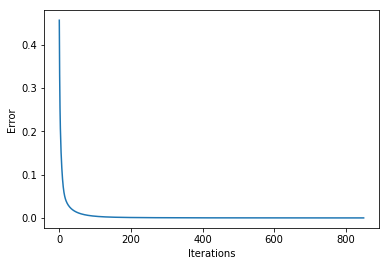

Dev Accuracy: 0.615071283095723
Playoff Accuracy: 0.6435845213849287


In [11]:
# General fit
NBA_lin = LinearRegression(step_size=1e-3, eps=1e-5)

teams_s, dates_s, results_s = shuffle(unique_teams, unique_dates, unique_game_results, random_state=0)
x_train, y_train = NBA_lin.process_data(teams_s[0:3935], dates_s[0:3935], results_s[0:3935])

NBA_lin.fit(x_train, y_train)

dev_accuracy = NBA_lin.general_predict(teams_s[3936:4427], dates_s[3936:4427], results_s[3936:4427])
print('Dev Accuracy: {}'.format(dev_accuracy))

prediction = NBA_lin.general_predict(teams_s[4428:4919], dates_s[4428:4919], results_s[4428:4919])
print('Playoff Accuracy: {}'.format(prediction))